# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
# data_set_oversampling = oversampling(separar_grupos_tvt(separar_classes(data_set)))
# print (data_set_oversampling)
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
over = oversampling_replacement(grupos)
print (len(over[0][0]), len(over[0][1]), len(over[0][2]), 
       len(over[1][0]), len(over[1][1]), len(over[1][2]))

join_c = join_class(over)
print (len(join_c[0]), len(join_c[1]), len(join_c[2]))

7592 253
3796 1898 1898 126 63 64
3796 1898 1898 3796 1898 64
7592 3796 1962


### Separando entrada de saida

In [11]:
X_train = join_c[0][:,:-1]
y_train = join_c[0][:,-1]

X_validation = join_c[1][:,:-1]
y_validation = join_c[1][:,-1]

X_test = join_c[2][:,:-1]
y_test = join_c[2][:,-1]
# print (y_validation)


# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({1.0: 3796, 0.0: 3796})
Counter({1.0: 1898, 0.0: 1898})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares.

In [13]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()

In [14]:
learnRate = 0.001
graficoName = "oversampling repetição, lr=0.001, rede="

## RNA 1 (10)

In [15]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) #

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 0s - loss: 0.3512 - acc: 0.5904 - val_loss: 0.4399 - val_acc: 0.5738
Epoch 2/100000
7592/7592 [==============================] - 0s - loss: 0.3032 - acc: 0.6592 - val_loss: 0.3898 - val_acc: 0.6014
Epoch 3/100000
7592/7592 [==============================] - 0s - loss: 0.2491 - acc: 0.6985 - val_loss: 0.3161 - val_acc: 0.6765
Epoch 4/100000
7592/7592 [==============================] - 0s - loss: 0.1925 - acc: 0.7383 - val_loss: 0.2386 - val_acc: 0.7421
Epoch 5/100000
7592/7592 [==============================] - 0s - loss: 0.1534 - acc: 0.7836 - val_loss: 0.1898 - val_acc: 0.7524
Epoch 6/100000
7592/7592 [==============================] - 0s - loss: 0.1315 - acc: 0.8350 - val_loss: 0.1613 - val_acc: 0.8153
Epoch 7/100000
7592/7592 [==============================] - 0s - loss: 0.1209 - acc: 0.8558 - val_loss: 0.1480 - val_acc: 0.8498
Epoch 8/100000
7592/7592 [=======================

KeyboardInterrupt: 

In [45]:
classifier.evaluate(X_test, y_test)
# print (test_loss)

1920/1962 [============================>.] - ETA: 0s

[0.053948230156627516, 0.93323139653414888]

<IPython.core.display.Javascript object>


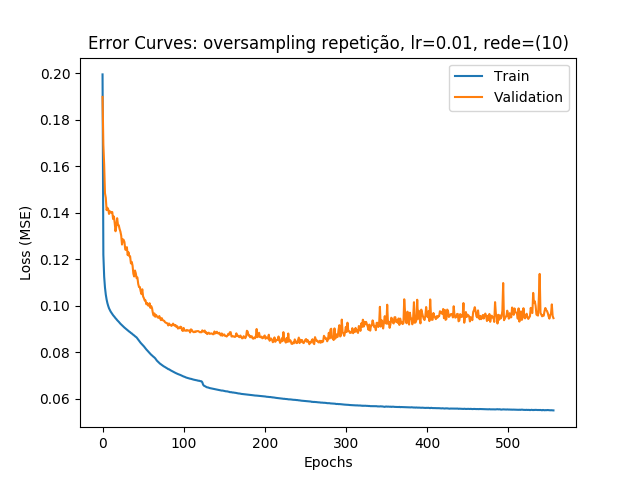

<IPython.core.display.Javascript object>


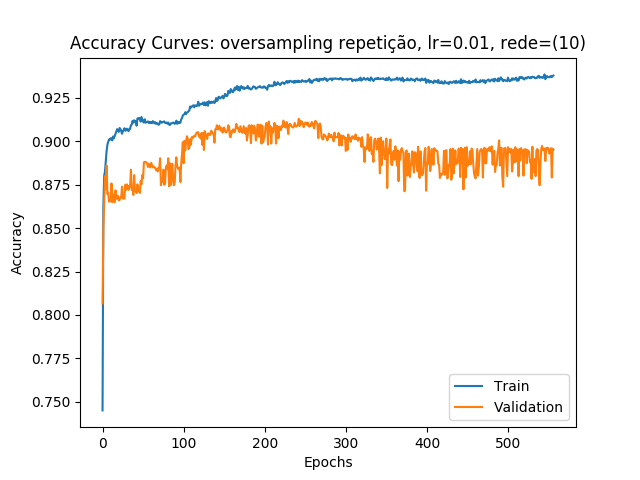

Matriz de confusão
[[1803   95]
 [   9   55]]

Train Loss:       0.0589
Validation Loss:  0.0834
Accuracy:         0.9470
MSE:              0.0530
AUROC:            0.9269


In [18]:
plot_training_error_curves(history, graficoName + "(10)")
plot_training_acc_curves(history, graficoName + "(10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (20)

In [47]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 0s - loss: 0.4148 - acc: 0.5308 - val_loss: 0.3987 - val_acc: 0.5551
Epoch 2/100000
7592/7592 [==============================] - 0s - loss: 0.3234 - acc: 0.5902 - val_loss: 0.3586 - val_acc: 0.5761
Epoch 3/100000
7592/7592 [==============================] - 0s - loss: 0.2664 - acc: 0.6677 - val_loss: 0.3255 - val_acc: 0.6420
Epoch 4/100000
7592/7592 [==============================] - 0s - loss: 0.2291 - acc: 0.7117 - val_loss: 0.2905 - val_acc: 0.7065
Epoch 5/100000
7592/7592 [==============================] - 0s - loss: 0.1928 - acc: 0.7480 - val_loss: 0.2477 - val_acc: 0.7221
Epoch 6/100000
7592/7592 [==============================] - 0s - loss: 0.1645 - acc: 0.7931 - val_loss: 0.2203 - val_acc: 0.7885
Epoch 7/100000
7592/7592 [==============================] - 0s - loss: 0.1381 - acc: 0.8143 - val_loss: 0.2046 - val_acc: 0.7919
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 0s - loss: 0.0810 - acc: 0.9070 - val_loss: 0.1050 - val_acc: 0.8759
Epoch 126/100000
7592/7592 [==============================] - 0s - loss: 0.0810 - acc: 0.9063 - val_loss: 0.1050 - val_acc: 0.8759
Epoch 127/100000
7592/7592 [==============================] - 0s - loss: 0.0809 - acc: 0.9062 - val_loss: 0.1047 - val_acc: 0.8759
Epoch 128/100000
7592/7592 [==============================] - 0s - loss: 0.0808 - acc: 0.9087 - val_loss: 0.1046 - val_acc: 0.8759
Epoch 129/100000
7592/7592 [==============================] - 0s - loss: 0.0808 - acc: 0.9071 - val_loss: 0.1046 - val_acc: 0.8759
Epoch 130/100000
7592/7592 [==============================] - 0s - loss: 0.0807 - acc: 0.9062 - val_loss: 0.1044 - val_acc: 0.8759
Epoch 131/100000
7592/7592 [==============================] - 0s - loss: 0.0806 - acc: 0.9086 - val_loss: 0.1043 - val_acc: 0.8759
Epoch 132/100000
7592/7592 [==============================] - 0s - loss: 0.0806 - acc: 0.9083 - val_

7592/7592 [==============================] - 0s - loss: 0.0750 - acc: 0.9103 - val_loss: 0.0973 - val_acc: 0.8862
Epoch 250/100000
7592/7592 [==============================] - 0s - loss: 0.0750 - acc: 0.9102 - val_loss: 0.0973 - val_acc: 0.8862
Epoch 251/100000
7592/7592 [==============================] - 0s - loss: 0.0749 - acc: 0.9104 - val_loss: 0.0972 - val_acc: 0.8862
Epoch 252/100000
7592/7592 [==============================] - 0s - loss: 0.0749 - acc: 0.9098 - val_loss: 0.0972 - val_acc: 0.8862
Epoch 253/100000
7592/7592 [==============================] - 0s - loss: 0.0749 - acc: 0.9100 - val_loss: 0.0971 - val_acc: 0.8862
Epoch 254/100000
7592/7592 [==============================] - 0s - loss: 0.0748 - acc: 0.9103 - val_loss: 0.0971 - val_acc: 0.8862
Epoch 255/100000
7592/7592 [==============================] - 0s - loss: 0.0748 - acc: 0.9099 - val_loss: 0.0971 - val_acc: 0.8862
Epoch 256/100000
7592/7592 [==============================] - 0s - loss: 0.0748 - acc: 0.9100 - val_

7592/7592 [==============================] - 0s - loss: 0.0713 - acc: 0.9133 - val_loss: 0.0944 - val_acc: 0.8867
Epoch 374/100000
7592/7592 [==============================] - 0s - loss: 0.0713 - acc: 0.9137 - val_loss: 0.0944 - val_acc: 0.8867
Epoch 375/100000
7592/7592 [==============================] - 0s - loss: 0.0713 - acc: 0.9140 - val_loss: 0.0944 - val_acc: 0.8867
Epoch 376/100000
7592/7592 [==============================] - 0s - loss: 0.0713 - acc: 0.9140 - val_loss: 0.0944 - val_acc: 0.8867
Epoch 377/100000
7592/7592 [==============================] - 0s - loss: 0.0712 - acc: 0.9141 - val_loss: 0.0944 - val_acc: 0.8867
Epoch 378/100000
7592/7592 [==============================] - 0s - loss: 0.0712 - acc: 0.9135 - val_loss: 0.0944 - val_acc: 0.8867
Epoch 379/100000
7592/7592 [==============================] - 0s - loss: 0.0712 - acc: 0.9139 - val_loss: 0.0944 - val_acc: 0.8867
Epoch 380/100000
7592/7592 [==============================] - 0s - loss: 0.0712 - acc: 0.9136 - val_

7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9195 - val_loss: 0.0939 - val_acc: 0.8886
Epoch 498/100000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9198 - val_loss: 0.0939 - val_acc: 0.8886
Epoch 499/100000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9195 - val_loss: 0.0939 - val_acc: 0.8886
Epoch 500/100000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9197 - val_loss: 0.0939 - val_acc: 0.8886
Epoch 501/100000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9197 - val_loss: 0.0939 - val_acc: 0.8886
Epoch 502/100000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9198 - val_loss: 0.0939 - val_acc: 0.8886
Epoch 503/100000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9197 - val_loss: 0.0939 - val_acc: 0.8886
Epoch 504/100000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9195 - val_

In [48]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1728/1962 [=========================>....] - ETA: 0s[0.045346897361262739, 0.93832823637185603]


<IPython.core.display.Javascript object>


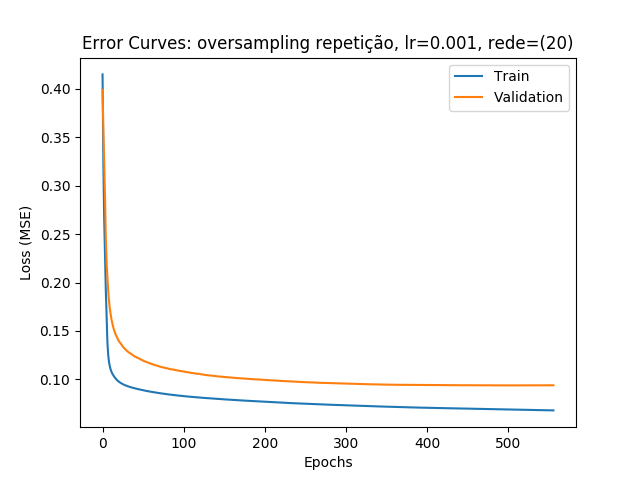

<IPython.core.display.Javascript object>


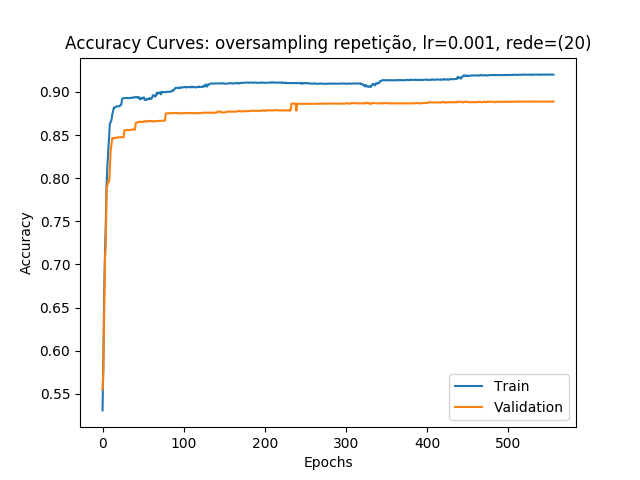

Matriz de confusão
[[1784  114]
 [   7   57]]

Train Loss:       0.0689
Validation Loss:  0.0938
Accuracy:         0.9383
MSE:              0.0617
AUROC:            0.9479


In [49]:
plot_training_error_curves(history, graficoName + "(20)")
plot_training_acc_curves(history, graficoName + "(20)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (10, 15)

In [30]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(10, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(15, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 0s - loss: 0.2915 - acc: 0.6067 - val_loss: 0.2657 - val_acc: 0.6304
Epoch 2/100000
7592/7592 [==============================] - 0s - loss: 0.2166 - acc: 0.6974 - val_loss: 0.2288 - val_acc: 0.6812
Epoch 3/100000
7592/7592 [==============================] - 0s - loss: 0.1865 - acc: 0.7346 - val_loss: 0.2054 - val_acc: 0.7047
Epoch 4/100000
7592/7592 [==============================] - 0s - loss: 0.1680 - acc: 0.7640 - val_loss: 0.1898 - val_acc: 0.7487
Epoch 5/100000
7592/7592 [==============================] - 0s - loss: 0.1553 - acc: 0.7916 - val_loss: 0.1790 - val_acc: 0.7779
Epoch 6/100000
7592/7592 [==============================] - 0s - loss: 0.1463 - acc: 0.8114 - val_loss: 0.1709 - val_acc: 0.7853
Epoch 7/100000
7592/7592 [==============================] - 0s - loss: 0.1394 - acc: 0.8211 - val_loss: 0.1650 - val_acc: 0.7908
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 0s - loss: 0.0788 - acc: 0.9110 - val_loss: 0.0981 - val_acc: 0.8714
Epoch 126/100000
7592/7592 [==============================] - 0s - loss: 0.0787 - acc: 0.9092 - val_loss: 0.0983 - val_acc: 0.8709
Epoch 127/100000
7592/7592 [==============================] - 0s - loss: 0.0786 - acc: 0.9099 - val_loss: 0.0983 - val_acc: 0.8704
Epoch 128/100000
7592/7592 [==============================] - 0s - loss: 0.0785 - acc: 0.9098 - val_loss: 0.0982 - val_acc: 0.8707
Epoch 129/100000
7592/7592 [==============================] - 0s - loss: 0.0784 - acc: 0.9085 - val_loss: 0.0976 - val_acc: 0.8714
Epoch 130/100000
7592/7592 [==============================] - 0s - loss: 0.0783 - acc: 0.9078 - val_loss: 0.0975 - val_acc: 0.8714
Epoch 131/100000
7592/7592 [==============================] - 0s - loss: 0.0782 - acc: 0.9075 - val_loss: 0.0973 - val_acc: 0.8728
Epoch 132/100000
7592/7592 [==============================] - 0s - loss: 0.0782 - acc: 0.9077 - val_

7592/7592 [==============================] - 0s - loss: 0.0713 - acc: 0.9070 - val_loss: 0.0915 - val_acc: 0.8830
Epoch 250/100000
7592/7592 [==============================] - 0s - loss: 0.0713 - acc: 0.9069 - val_loss: 0.0915 - val_acc: 0.8822
Epoch 251/100000
7592/7592 [==============================] - 0s - loss: 0.0713 - acc: 0.9067 - val_loss: 0.0914 - val_acc: 0.8833
Epoch 252/100000
7592/7592 [==============================] - 0s - loss: 0.0712 - acc: 0.9067 - val_loss: 0.0914 - val_acc: 0.8836
Epoch 253/100000
7592/7592 [==============================] - 0s - loss: 0.0712 - acc: 0.9073 - val_loss: 0.0915 - val_acc: 0.8833
Epoch 254/100000
7592/7592 [==============================] - 0s - loss: 0.0712 - acc: 0.9073 - val_loss: 0.0914 - val_acc: 0.8833
Epoch 255/100000
7592/7592 [==============================] - 0s - loss: 0.0711 - acc: 0.9074 - val_loss: 0.0914 - val_acc: 0.8825
Epoch 256/100000
7592/7592 [==============================] - 0s - loss: 0.0711 - acc: 0.9069 - val_

7592/7592 [==============================] - 0s - loss: 0.0677 - acc: 0.9185 - val_loss: 0.0896 - val_acc: 0.8775
Epoch 374/100000
7592/7592 [==============================] - 0s - loss: 0.0677 - acc: 0.9183 - val_loss: 0.0896 - val_acc: 0.8775
Epoch 375/100000
7592/7592 [==============================] - 0s - loss: 0.0676 - acc: 0.9185 - val_loss: 0.0896 - val_acc: 0.8775
Epoch 376/100000
7592/7592 [==============================] - 0s - loss: 0.0676 - acc: 0.9179 - val_loss: 0.0895 - val_acc: 0.8775
Epoch 377/100000
7592/7592 [==============================] - 0s - loss: 0.0676 - acc: 0.9183 - val_loss: 0.0895 - val_acc: 0.8775
Epoch 378/100000
7592/7592 [==============================] - 0s - loss: 0.0676 - acc: 0.9186 - val_loss: 0.0895 - val_acc: 0.8778
Epoch 379/100000
7592/7592 [==============================] - 0s - loss: 0.0675 - acc: 0.9185 - val_loss: 0.0895 - val_acc: 0.8775
Epoch 380/100000
7592/7592 [==============================] - 0s - loss: 0.0675 - acc: 0.9189 - val_

7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9206 - val_loss: 0.0891 - val_acc: 0.8796
Epoch 498/100000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9206 - val_loss: 0.0891 - val_acc: 0.8796
Epoch 499/100000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9210 - val_loss: 0.0890 - val_acc: 0.8799
Epoch 500/100000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9204 - val_loss: 0.0891 - val_acc: 0.8799
Epoch 501/100000
7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9210 - val_loss: 0.0892 - val_acc: 0.8791
Epoch 502/100000
7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9204 - val_loss: 0.0890 - val_acc: 0.8799
Epoch 503/100000
7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9204 - val_loss: 0.0891 - val_acc: 0.8799
Epoch 504/100000
7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9204 - val_

In [19]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1632/1962 [=======================>......] - ETA: 0s[0.052386035601571429, 0.93068297655453613]


<IPython.core.display.Javascript object>


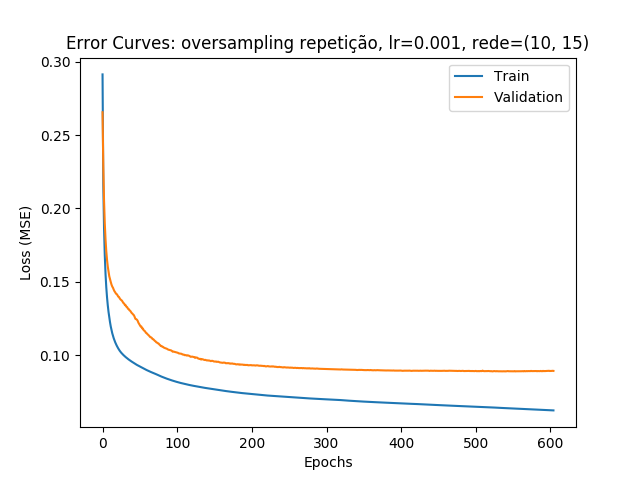

<IPython.core.display.Javascript object>


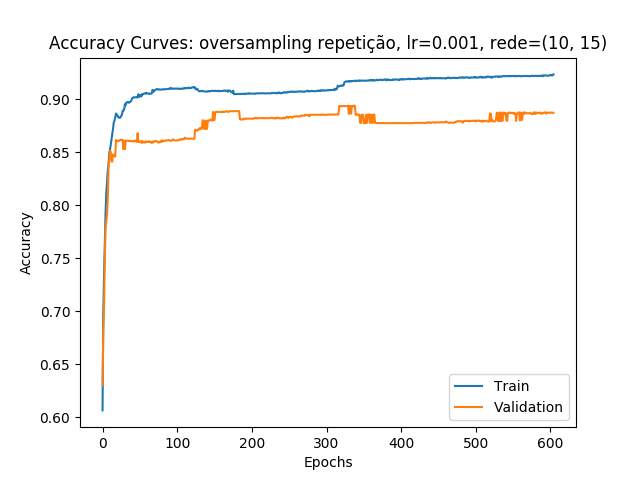

Matriz de confusão
[[1787  111]
 [   7   57]]

Train Loss:       0.0635
Validation Loss:  0.0889
Accuracy:         0.9399
MSE:              0.0601
AUROC:            0.9476


In [31]:
plot_training_error_curves(history, graficoName + "(10, 15)")
plot_training_acc_curves(history, graficoName + "(10, 15)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (20, 10)

In [24]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(20, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(10, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

sgd = optimizers.SGD(lr=learnRate)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

history = classifier.fit(X_train, y_train,
                         epochs=100000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation),
                         callbacks=[early_stopping])

Train on 7592 samples, validate on 3796 samples
Epoch 1/100000
7592/7592 [==============================] - 0s - loss: 0.1988 - acc: 0.7650 - val_loss: 0.1815 - val_acc: 0.8396
Epoch 2/100000
7592/7592 [==============================] - 0s - loss: 0.1072 - acc: 0.8915 - val_loss: 0.1445 - val_acc: 0.8633
Epoch 3/100000
7592/7592 [==============================] - 0s - loss: 0.0964 - acc: 0.8971 - val_loss: 0.1303 - val_acc: 0.8767
Epoch 4/100000
7592/7592 [==============================] - 0s - loss: 0.0908 - acc: 0.8983 - val_loss: 0.1225 - val_acc: 0.8749
Epoch 5/100000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.8981 - val_loss: 0.1166 - val_acc: 0.8754
Epoch 6/100000
7592/7592 [==============================] - 0s - loss: 0.0846 - acc: 0.8984 - val_loss: 0.1108 - val_acc: 0.8796
Epoch 7/100000
7592/7592 [==============================] - 0s - loss: 0.0824 - acc: 0.9016 - val_loss: 0.1085 - val_acc: 0.8783
Epoch 8/100000
7592/7592 [=======================

7592/7592 [==============================] - 0s - loss: 0.0540 - acc: 0.9468 - val_loss: 0.0972 - val_acc: 0.8857
Epoch 126/100000
7592/7592 [==============================] - 0s - loss: 0.0539 - acc: 0.9465 - val_loss: 0.0981 - val_acc: 0.8878
Epoch 127/100000
7592/7592 [==============================] - 0s - loss: 0.0539 - acc: 0.9468 - val_loss: 0.0970 - val_acc: 0.8859
Epoch 128/100000
7592/7592 [==============================] - 0s - loss: 0.0538 - acc: 0.9460 - val_loss: 0.0979 - val_acc: 0.8867
Epoch 129/100000
7592/7592 [==============================] - 0s - loss: 0.0537 - acc: 0.9460 - val_loss: 0.0973 - val_acc: 0.8854
Epoch 130/100000
7592/7592 [==============================] - 0s - loss: 0.0536 - acc: 0.9459 - val_loss: 0.0989 - val_acc: 0.8888
Epoch 131/100000
7592/7592 [==============================] - 0s - loss: 0.0536 - acc: 0.9467 - val_loss: 0.0980 - val_acc: 0.8870
Epoch 132/100000
7592/7592 [==============================] - 0s - loss: 0.0535 - acc: 0.9463 - val_

7592/7592 [==============================] - 0s - loss: 0.0476 - acc: 0.9523 - val_loss: 0.1101 - val_acc: 0.8749
Epoch 250/100000
7592/7592 [==============================] - 0s - loss: 0.0476 - acc: 0.9530 - val_loss: 0.1169 - val_acc: 0.8678
Epoch 251/100000
7592/7592 [==============================] - 0s - loss: 0.0476 - acc: 0.9524 - val_loss: 0.1102 - val_acc: 0.8728
Epoch 252/100000
7592/7592 [==============================] - 0s - loss: 0.0476 - acc: 0.9524 - val_loss: 0.1099 - val_acc: 0.8722
Epoch 253/100000
7592/7592 [==============================] - 0s - loss: 0.0474 - acc: 0.9519 - val_loss: 0.1108 - val_acc: 0.8751
Epoch 254/100000
7592/7592 [==============================] - 0s - loss: 0.0475 - acc: 0.9527 - val_loss: 0.1115 - val_acc: 0.8670
Epoch 255/100000
7592/7592 [==============================] - 0s - loss: 0.0475 - acc: 0.9530 - val_loss: 0.1104 - val_acc: 0.8738
Epoch 256/100000
7592/7592 [==============================] - 0s - loss: 0.0473 - acc: 0.9528 - val_

In [22]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1408/1962 [====================>.........] - ETA: 0s[0.049675309252311693, 0.93577981651376152]


<IPython.core.display.Javascript object>


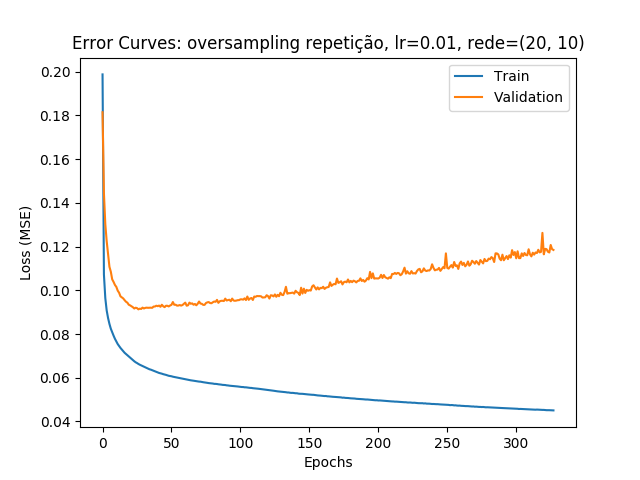

<IPython.core.display.Javascript object>


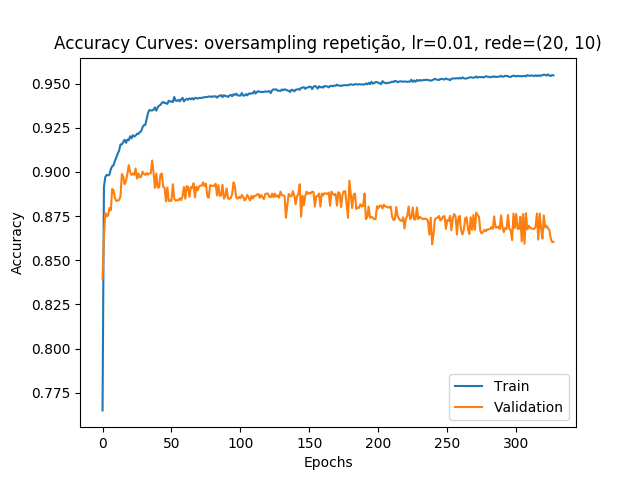

Matriz de confusão
[[1831   67]
 [  12   52]]

Train Loss:       0.0663
Validation Loss:  0.0913
Accuracy:         0.9597
MSE:              0.0403
AUROC:            0.9234


In [25]:
plot_training_error_curves(history, graficoName + "(20, 10)")
plot_training_acc_curves(history, graficoName + "(20, 10)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))